<a href="https://colab.research.google.com/github/lvllvl/parallel_processing/blob/main/imageToGrayscale_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install imageio

<ipython-input-39-c2fbf440c811>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread( filename )


(622, 584, 4)


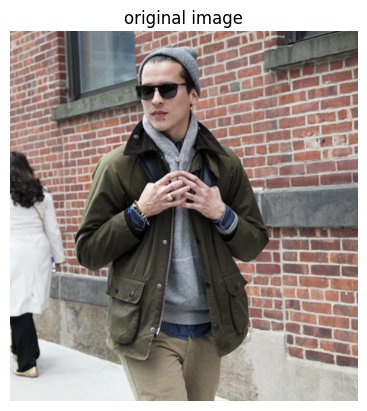

(622, 584)


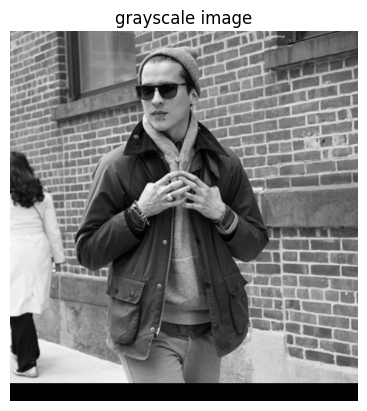

In [39]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from numba import cuda

@cuda.jit
def colorToGrayscaleConvertion(Pout, Pin, width, height):
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    CHANNELS = 3

    if col < width and row < height:
        # Get ID offset for the grayscale image
        grayOffset = row * width + col
        # One can think of the RGB image having CHANNELS times more columns than the gray scale image
        rgbOffset = grayOffset * CHANNELS
        r = Pin[rgbOffset]      # Red value
        g = Pin[rgbOffset + 1]  # Green value
        b = Pin[rgbOffset + 2]  # Blue value

        # Perform the rescaling and store it
        grayscale_value = 0.21 * r + 0.71 * g + 0.07 * b
        Pout[grayOffset] = np.uint8( grayscale_value )


# 1. upload the image
filename = '/content/drive/MyDrive/images/color_photo.png'
img = imageio.imread( filename )
img = img.astype( np.uint8 )
print( img.shape )

# Slice the image BEFORE
if img.shape[2] == 4:
    img = img[:, :, :3]



# 2. load and display the image
plt.imshow(img)
plt.axis('off')
plt.title("original image")
plt.show()

# 3. convert the image to grayscale using the cuda kernel
height, width, _ = img.shape
pin_host_flat = img.flatten().astype(np.uint8)


# allocate device memory and copy data to device
pin_device = cuda.to_device( pin_host_flat )
pout_device = cuda.device_array((img.shape[0] * img.shape[1],), dtype=np.uint8)


# define block and grid dimensions
threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil( img.shape[0] / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil( img.shape[1] / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# call the kernel
colorToGrayscaleConvertion[ blocks_per_grid, threads_per_block ]( pout_device, pin_device, img.shape[1], img.shape[0] )

# copy the result back to the host
pout_host = pout_device.copy_to_host().reshape( img.shape[0], img.shape[1] )

# 4. display the grayscale image
print( pout_host.shape ) # print shape
plt.imshow(pout_host, cmap='gray')
plt.axis('off')
plt.title("grayscale image")
plt.show()